<a href="https://colab.research.google.com/github/amecchina/lezioni_NLP/blob/main/case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/andreamecchina/lezioni_NLP/blob/main/case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio di Linguistica Computazionale

L'obiettivo di questo laboratorio è prendere confidenza con gli strumenti teorici introdotti nelle ore precedente e metterli in pratica andando ad analizzare un vero corpus di documenti.

Per poter eseguire questo notebook in Google Colab, dobbiamo installare prima tre pacchetti non compresi tra quelli di default.

In [1]:
! pip install GitPython
! pip install flair
! pip install IProgress

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.1/203.1 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.5 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=e7e5278b41a7ae7968c12271d7d13a7c238c2a91c6ee52b279523d165bc0d2f6
  Stored in directory: /root/.cache/pip

Andiamo ad importare le librerie Python e gli oggetti che andremo ad impiegare:
+ useremo la libreria ```GitPython``` per clonare la repository di GitHub contenente i dati;
+ useremo anche i moduli built-in di Python ```os``` e ```shutil``` per interfacciarci con il nostro sistema operativo;
+ ```NLTK``` è la principale libreria di riferimento per il processamento di dati testuali, acronimo di Natural Language Toolkit;
+ per gestire dataframe utilizzeremo invece la libreria ```pandas```;
+ per visualizzare le word clouds dei documenti utilizzeremo la libreria ```wordcloud```;
+ ```matplotlib``` è la principale libreria che utilizzeremo per realizzare figure e grafici;
+ per calcolare la TF-IDF utilizzeremo la libreria ```scikit-learn```, una libreria con moltissime strumenti di analisi dati e intelligenza artificiale, che useremo anche per il calcolo delle componenti principali, per separare dati di train e dati di test, per provare diversi classificatori e per valutarne i risultati;
+ useremo la libreria ```spacy``` per effettuare Part-of-Speech (PoS) tagging e lemmatizzazione del testi in maniera specifica per la lingua italiana;
+ ```flair```è la libreria che utilizzaremo per costruire gli embedding di token e di frasi;
+ utilizzeremo la libreria ```numpy``` per eseguire operazioni tra vettori.

In [2]:
import os
import git
import shutil
from nltk.corpus import PlaintextCorpusReader, stopwords
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from flair.embeddings import WordEmbeddings
from flair.data import Sentence
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

Andiamo a scaricare tutte le componenti aggiungitive che andremo poi ad utilizzare durante il resto del notebook.

In [9]:
import nltk

nltk.download("punkt_tab")
nltk.download("stopwords")
spacy.cli.download("it_core_news_sm")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Nella cartella ```data``` abbiamo raccolto i documenti di testo che vogliamo andare ad analizzare, nel formato ```.txt```, cioè come semplici file di testo. Qui abbiamo raccolto le versioni complete di 3 romanzi italiani:
+ Ultime lettere di Jacopo Ortis (1802) di Ugo Foscolo;  
+ I promessi sposi (1840) di Alessandro Manzoni;
+ La luna e i falò (1950) di Cesare Pavese.
Questi romanzi sono stati scelti affinché i primi due fossero pressappoco contemporanei, mentre il terzo fosse di oltre un secolo posteriore ai primi due.

La cartella di dati viene scaricata da una repository GitHub ("https://github.com/andreamecchina/lezioni_NLP.git") in cui ho caricati i file di testo, insieme a questo notebook. Andiamo a scaricare questi documenti in locale e a creare la cartella, se non ne esiste già una in questa directory. Facciamo uso di una cartella temporanea che andiamo poi ad eliminare.

In [10]:
if not os.path.exists("./data"):
    repo_path = "./temp"
    git.Repo.clone_from("https://github.com/andreamecchina/lezioni_NLP.git", repo_path)
    shutil.move(os.path.join(repo_path, "data"), "./")
    shutil.rmtree(repo_path)

Andiamo a specificare il percorso in cui abbiamo raccolti i file di testo in questione e andiamo ad importarli usando l'oggetto ```PlaintextCorpusReader```. Questo oggetto permette di leggere uno alla volta tutti i file nel formato ```.txt``` all'interno del percorso che abbiamo specificato.

In [11]:
corpus = PlaintextCorpusReader("./data", r".*\.txt")

Questo oggetto è in grado, internamente, di processare uno alla volta ogni file di testo del nostro corpus e di tokenizzare, ovvero di dividere in parole, ciascun file di testo.

Il metodo ```fileids``` dell'oggetto ```PlaintextCorpusReader``` ci restituisce una lista dei testi che sono stati identificati dalla libreria. Verifichiamo che questi siano correttamente i tre file che sono contenuti nella cartella di input.

In [12]:
files = corpus.fileids()
print(files)

['i_promessi_sposi.txt', 'la_luna_e_i_falò.txt', 'ultime_lettere_di_jacopo_ortis.txt']


Andiamo a creare un dataframe ```parsing``` in cui riportare delle statistiche basilari per ciascuno documento del corpus che abbiamo costruito. In particolare, per ciascun documento andiamo a riportare il numero di paragrafi, di frasi e di parole, utilizzando i metodi relativi dell'oggetto ```PlaintextCorpusReader```.

Vediamo che I promessi sposi è il romanzo più lungo dei 3, con il maggior numero di parole e, prevedibilmente, di frasi e di parafrafi. I conteggi per La luna e i falò e Ultime lettere di Jacopo Ortis non sono invece così diversi.

In [13]:
names = ["I promessi sposi", "La luna e i falò", "Ultime lettere di Jacopo Ortis"]
parsing = pd.DataFrame(index=names)
parsing["Paragrafi"] = [len(corpus.paras(fileids=file)) for file in files]
parsing["Frasi"] = [len(corpus.sents(fileids=file)) for file in files]
parsing["Parole"] = [len(corpus.words(fileids=file)) for file in files]
display(parsing)

,Paragrafi,Frasi,Parole
I promessi sposi,3005,10439,282255
La luna e i falò,680,2673,52596
Ultime lettere di Jacopo Ortis,535,2577,60174


Una visualizzazione utile della frequenza dei token, che nel nostro caso corrispondono alle parole del testo, è attraverso le cosiddette word cloud, o nuvole di parole. In questo tipo di figure, più grande appare una parola, maggiore è la sua frequenza nel documento considerato.

Andiamo quindi a calcolare un dizionario con le frequenze dei token in ciascuno dei tre testi a disposizione.

Mentre la divisione in paragrafi e frasi è, almeno in linea di principio, indipendente dalla lingua del documento, ci possiamo aspettare che invece la tokenizzazione dipenda dalla lingua delle parole. A tal proposito, vogliamo applicare ora una tokenizzazione specifica per la lingua italiana e non più quella inglese, applicata di default dal metodo usato in precedenza.

Andiamo ad utilizzare la funzione ```word_tokenize``` per creare, per ciascun documento, una lista dei token. Usiamo un metodo `dell'oggetto ```PlaintextCorpusReader``` per ottenere restituisce il documento grezzo, così da poterci applicare una tokenizzazione specifica per la lingua italiana. Andiamo a convertire tutti i token in minuscolo.

In [14]:
tokens = {
    name: word_tokenize(corpus.raw(file).lower(), language="italian")
    for name, file in zip(names, files)
}

Andiamo poi ad utilizzare il metodo ```FreqDist``` per calcolare la distribuzione dei token che abbiamo appena ottenuto per ciascun romanzo.

In [15]:
tokens_freqs = {name: FreqDist(tokens[name]) for name in names}

Andiamo ora a realizzare un grafico word cloud per il testo de I promessi sposi, partendo dalla tokenizzazione appena ottenuta.

Quello che possiamo osservare è che, nonostante compaiano alcune parole tipiche del romanzo in questione, le parole più grandi, dunque le più frequenti, sono parole molto comuni che non hanno alcun contenuto informativo riguardo al romanzo in questione.

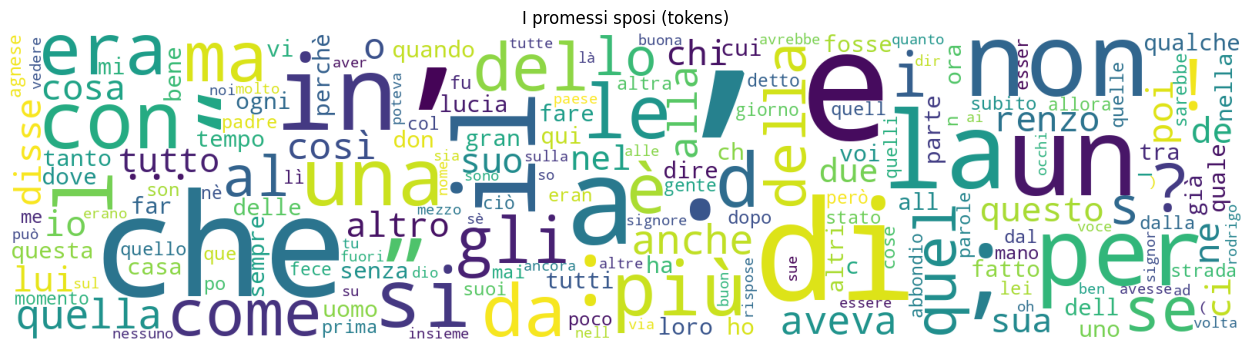

In [16]:
fig, ax = plt.subplots(figsize=(16, 4), dpi=100)
ax.set_title("I promessi sposi (tokens)")
ax.imshow(
    WordCloud(
        width=1600, height=400, background_color="white"
    ).generate_from_frequencies(tokens_freqs["I promessi sposi"])
)
ax.axis("off")
plt.show()

Le parole di uso comune, a basso contenuto informativo, sono dette stop words. Queste sono proprio di ciascuna lingua e una lista di quelle proprie della lingua italiana è disponibile tramite il metodo ```words``` di un oggetto adibito che abbiamo importato.

In [17]:
stop_words = set(stopwords.words("italian"))
print(stop_words)

{'su', 'questa', 'staresti', 'facevate', 'facciate', 'facessi', 'farebbe', 'i', 'farai', 'stavi', 'avevi', 'staranno', 'facessero', 'starete', 'suoi', 'sta', 'stesse', 'anche', 'tuoi', 'aveste', 'starai', 'stava', 'nei', 'avrò', 'dell', 'erano', 'contro', 'fareste', 'faresti', 'stemmo', 'facevano', 'cui', 'più', 'stettero', 'coi', 'nostre', 'gli', 'io', 'avessero', 'sarebbe', 'fummo', 'dello', 'sullo', 'avrebbe', 'agl', 'furono', 'stiate', 'nostra', 'sugli', 'loro', 'questo', 'feci', 'siete', 'stavo', 'vostro', 'tutto', 'starebbero', 'faceva', 'abbiamo', 'agli', 'avuto', 'mie', 'fece', 'stiano', 'foste', 'facesse', 'avreste', 'tutti', 'stessero', 'come', 'facendo', 'facevo', 'degl', 'sulla', 'suo', 'essendo', 'degli', 'per', 'avevo', 'starebbe', 'avete', 'sono', 'perché', 'mia', 'sarete', 'al', 'negli', 'sarai', 'siamo', 'e', 'non', 'avesse', 'saremo', 'delle', 'stetti', 'un', 'steste', 'eravamo', 'era', 'tra', 'farete', 'vostre', 'avevano', 'da', 'sull', 'a', 'avrete', 'dalla', 'avrem

Queste parole sono tipiche della lingua italiana moderna e contemporanea e quindi ci aspettiamo che siano adeguate per analizzare i nostri documenti, tutti successivi al 1800. Per documenti di parecchi secoli precedenti, forse queste stop words non sarebbero state adeguate.

Andiamo adesso a rimuovere le stop words dalle tokenizzazioni dei 3 documenti che abbiamo ottenuto prima. Andiamo anche a scartare tutto ciò che non è un carattere alfanumerico, come per esempio simboli di spaziatura e quant'altro. Successivamente, andiamo a calcolare la frequenza di frequenza dei token dopo aver eliminato le stop words.

In [18]:
cleaned_tokens = {
    name: [word for word in tokens[name] if word.isalnum() and word not in stop_words]
    for name in names
}
cleaned_tokens_freqs = {name: FreqDist(cleaned_tokens[name]) for name in names}

Per confronto, andiamo adesso a realizzare un grafico word cloud per con la nuova lista di token, dopo aver eliminato le stop words.

Nonostante rimangano ancora alcune parole e lemmi poco informativi riguardo al romanzo, da questa word cloud è possibile risalire al romanzo in questione: in questo modo, questa figura diventa un utile strumento di sintesi di un documento anche molto esteso, come in questo caso.

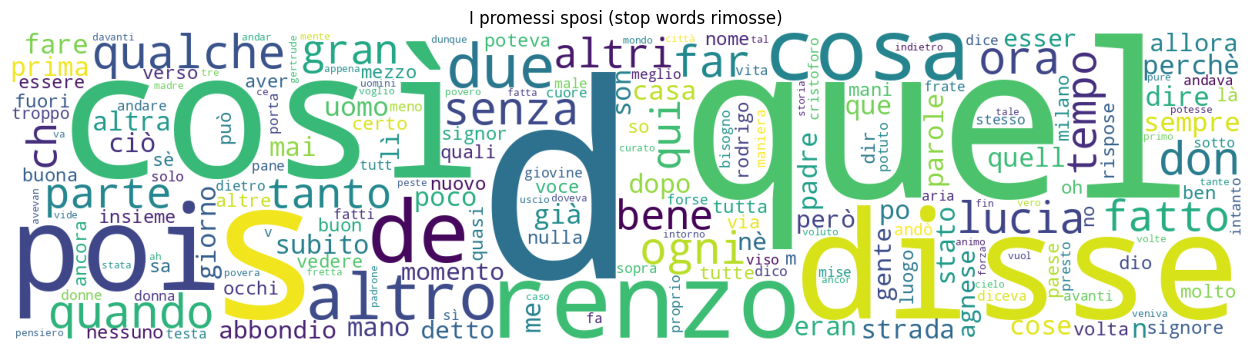

In [19]:
fig, ax = plt.subplots(figsize=(16, 4), dpi=100)
ax.set_title("I promessi sposi (stop words rimosse)")
ax.imshow(
    WordCloud(
        width=1600, height=400, background_color="white"
    ).generate_from_frequencies(cleaned_tokens_freqs["I promessi sposi"])
)
ax.axis("off")
plt.show()

Sempre per un confronto, andiamo adesso a realizzare la figura relativa a La luna e i falò. La figura presenta termini più frequenti decisamente diversi rispetto a I promessi sposi, caratterizzando quindi in maniera diversa i due romanzi.

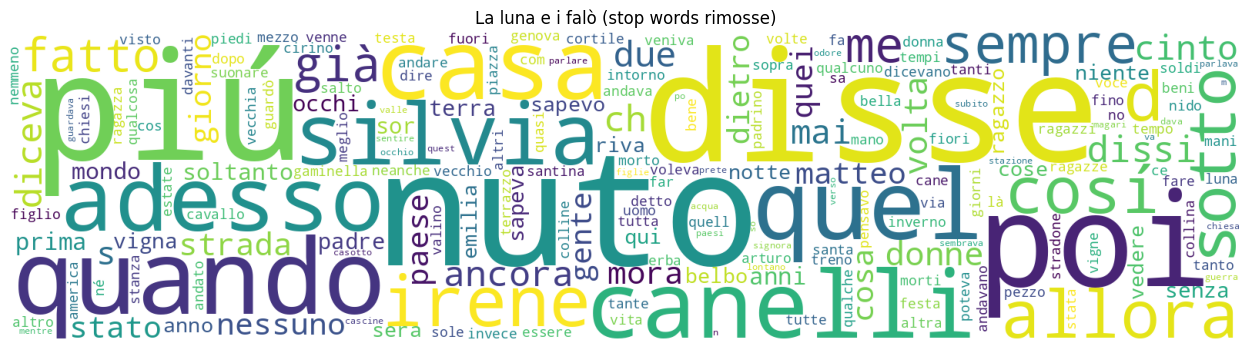

In [20]:
fig, ax = plt.subplots(figsize=(16, 4), dpi=100)
ax.set_title("La luna e i falò (stop words rimosse)")
ax.imshow(
    WordCloud(
        width=1600, height=400, background_color="white"
    ).generate_from_frequencies(cleaned_tokens_freqs["La luna e i falò"])
)
ax.axis("off")
plt.show()

Riportiamo infine la stessa figura anche per l'ultimo documento considerato, Ultime lettere di Jacopo Ortis. Restano valide tutte le considerazioni fatte precedentemente: emergono dalla word cloud alcune parole chiave, caratterizzanti questo romanzo.

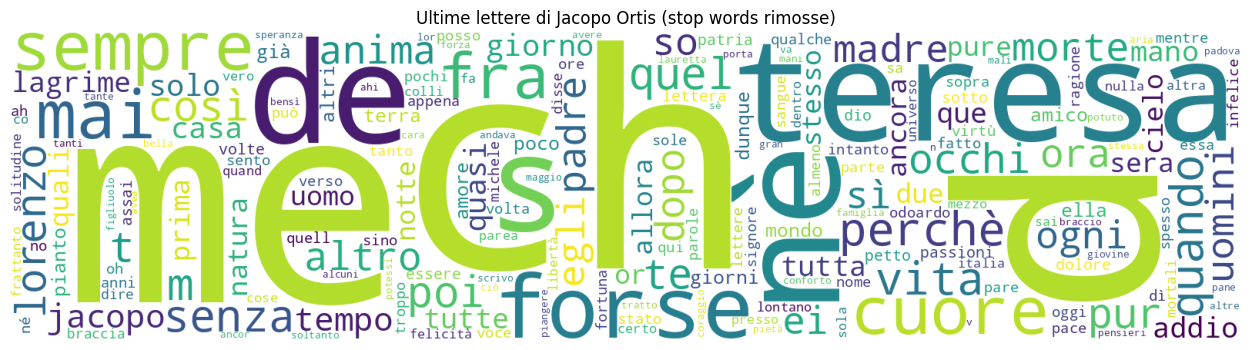

In [21]:
fig, ax = plt.subplots(figsize=(16, 4), dpi=100)
ax.set_title("Ultime lettere di Jacopo Ortis (stop words rimosse)")
ax.imshow(
    WordCloud(
        width=1600, height=400, background_color="white"
    ).generate_from_frequencies(cleaned_tokens_freqs["Ultime lettere di Jacopo Ortis"])
)
ax.axis("off")
plt.show()

Le word clouds che abbiamo appena visto visualizzano con un carattere più grande le parole, tolte le stop words, con la maggiore frequenza in ciascun documento. Un'altra misura interessante che possiamo andare a considerare al posto della frequenza è la TF-IDF, che va a considerare anche quanto ciascuna parola è caratteristica di ciascun documento.

Andiamo di seguito a creare l'oggetto ```TfidfVectorizer``` e a costruire la matrice dei valori TF-IDF.

In [22]:
vectorizer = TfidfVectorizer()
TF_IDF_matrix = vectorizer.fit_transform(
    [" ".join(tokens) for tokens in cleaned_tokens.values()]
).todense()

Adesso che abbiamo un unico oggetto matriciale che contiene tutti i pesi, andiamo ad oranizzarli in un dizionario con tre ingressi, uno per ciascun documento del nostro corpus.

In [23]:
TF_IDF_weights = {}
for index, name in enumerate(names):
    TF_IDF_values = TF_IDF_matrix[index].tolist()[0]
    TF_IDF_weights[name] = dict(zip(vectorizer.get_feature_names_out(), TF_IDF_values))

Possiamo andare adesso a visualizzare le word clouds che otteniamo in questo modo, quindi dove la dimensione delle parole è data dal valore di TF-IDF e non più dal solo valore di frequenza (che indichiremmo in questo contesto con TF).

Vediamo che in questo modo, emergono ancora di più termini relativi propriamente al documento considerato.

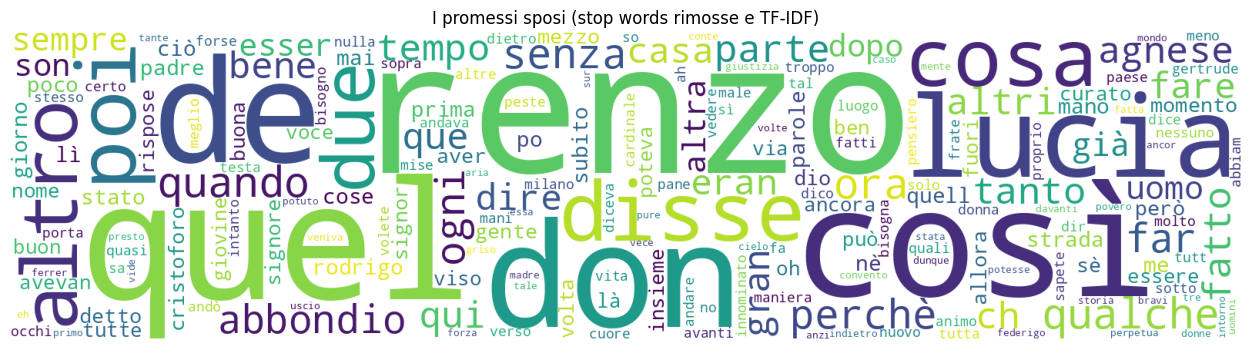

In [24]:
fig, ax = plt.subplots(figsize=(16, 4), dpi=100)
ax.set_title("I promessi sposi (stop words rimosse e TF-IDF)")
ax.imshow(
    WordCloud(
        width=1600, height=400, background_color="white"
    ).generate_from_frequencies(TF_IDF_weights["I promessi sposi"])
)
ax.axis("off")
plt.show()

Riportiamo di seguito la word cloud anche per La luna e i falò, in cui vediamo che sembrano apparire più grandi i termini più caratterizzanti del documento in questione.

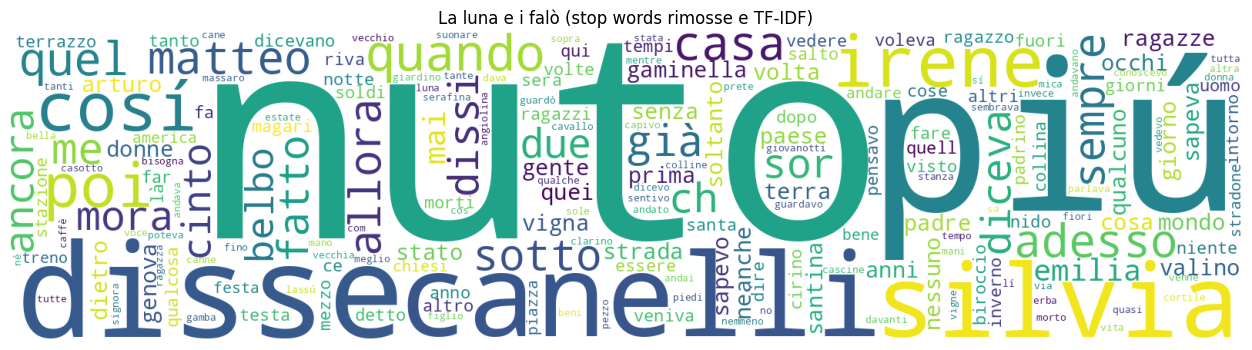

In [25]:
fig, ax = plt.subplots(figsize=(16, 4), dpi=100)
ax.set_title("La luna e i falò (stop words rimosse e TF-IDF)")
ax.imshow(
    WordCloud(
        width=1600, height=400, background_color="white"
    ).generate_from_frequencies(TF_IDF_weights["La luna e i falò"])
)
ax.axis("off")
plt.show()

Infine, nella figura successiva riportiamo la word cloud ottenuta tramite TF-IDF anche per il romanzo Ultime lettere di Jacopo Ortis. Anche qui, questo sistema di peso delle parole, più accurato della semplice frequenza dei token, sembra avere un impatto positivo.

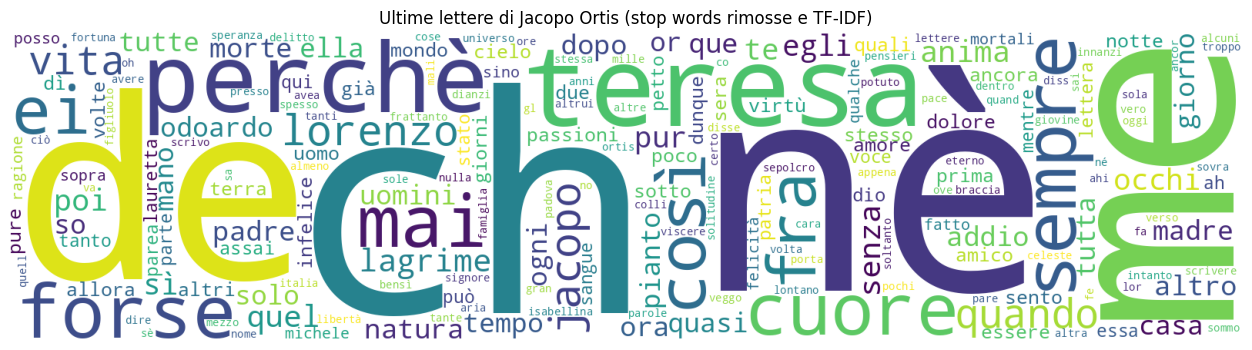

In [26]:
fig, ax = plt.subplots(figsize=(16, 4), dpi=100)
ax.set_title("Ultime lettere di Jacopo Ortis (stop words rimosse e TF-IDF)")
ax.imshow(
    WordCloud(
        width=1600, height=400, background_color="white"
    ).generate_from_frequencies(TF_IDF_weights["Ultime lettere di Jacopo Ortis"])
)
ax.axis("off")
plt.show()

Per effettuare il PoS tagging e la lemmatizzazione dobbiamo scaricare un modello specificatamente addestrato sulla lingua italiana. Abbiamo a disposizione un modello chiamato ```it_core_news_sm```, che nello specifico è stato allenato a partire da notizie giornalistiche.

Il codice di seguito carica il modello scaricato in precedenza. Andiamo poi a creare un oggetto ```nlp``` che useremo per effettuare il PoS tagging e per la lemmatizzazione.

In [27]:
nlp = spacy.load("it_core_news_sm")

D'ora in poi lavoreremo sempre sui documenti da cui abbiamo rimosso le stop words. Siccome il limite di caratteri di default di ```spacy``` è di $1000000$, per essere sicuri di non eccedere questo limite, lo impostiamo uguale al numero token (eliminando le stop words) de I promessi sposi, in quanto questo è il documento più lungo tra quelli considerati.

In [28]:
nlp.max_length = len(" ".join(cleaned_tokens["I promessi sposi"]))
print(nlp.max_length)

882962


Possiamo adesso effettuare il PoS tagging e la lemmatizzazione dei nostri tre documenti. Per ciascuno, andiamo a creare un dataframe con tante righe quanti sono gli elementi del testo processato e tre colonne:
+ la prima conterrà i token del testo originali;
+ la seconda conterrà i lemmi delle parole riconosciuto dall'algoritmo di lemmatizzazione;
+ la terza conterrà gli elementi logici del discorso riconosciuti dall'algoritmo di PoS;

Andiamo poi a salvare i dataframe ottenuti come elementi di un dizionario. Queste operazioni possono richiedere un po' di tempo.

In [29]:
part_of_speech_tags = {}
for name in names:
    print(f"{name}...")
    doc = nlp(" ".join(cleaned_tokens[name]))
    part_of_speech_tags[name] = pd.DataFrame(
        [(token.text, token.lemma_, token.pos_) for token in doc],
        columns=["Token", "Lemma", "PoS"],
    )

I promessi sposi...
La luna e i falò...
Ultime lettere di Jacopo Ortis...


I valori possibili degli elementi logici identificati dall'algoritmo di PoS tagging sono in numero limitato. Questi valori sono riportati nella documentazione di  ```spacy``` (accessibile al link: https://universaldependencies.org/u/pos/) e per comodità li riportiamo anche di seguito:

Tag       | Parte del discorso       
----------|--------------------------
ADJ       | Aggettivo                
ADP       | Apposizione              
ADV       | Avverbio                 
AUX       | Ausiliare                
CCONJ     | Congiunzione Coordinante
DET       | Articolo Determinativo   
INTJ      | Interiezione             
NOUN      | Nome                     
NUM       | Numero                   
PART      | Particella               
PRON      | Pronome                  
PROPN     | Nome Proprio             
PUNCT     | Punteggiatura            
SCONJ     | Congiunzione Subordinante
SPACE     | Spazio                   
SYM       | Simbolo                  
VERB      | Verbo                    
X         | Altro                    

Possiamo andare anche a visualizzare la distribuzione di frequenza dei tag ottenuti dall'algoritmo di PoS tagging. Andiamo a costuire un dataframe con le frequenze, per ciascun documento, dei diversi tag che abbiamo individuato.

In [30]:
tag_frequencies = pd.DataFrame(columns=names)
for name in names:
    tag_frequencies[name] = part_of_speech_tags[name]["PoS"].value_counts(
        normalize=True
    )
tag_frequencies.fillna(0.0, inplace=True)
display(tag_frequencies)

,I promessi sposi,La luna e i falò,Ultime lettere di Jacopo Ortis
PoS,,,
NOUN,0.268528,0.291539,0.278277
VERB,0.252257,0.279403,0.240463
ADJ,0.173465,0.167511,0.190846
ADV,0.100116,0.087095,0.094757
AUX,0.042267,0.039509,0.027824
ADP,0.040896,0.033747,0.040367
DET,0.037109,0.025976,0.028712
PROPN,0.027700,0.030778,0.023532
PRON,0.027497,0.022352,0.034891


Possiamo andare a visualizzare un grafico a barre per confrontare a colpo d'occhio le divese frequenze nei tre documenti considerati, in modo da catturare anche sottili differenze negli stili della scrittura dei diversi autori.

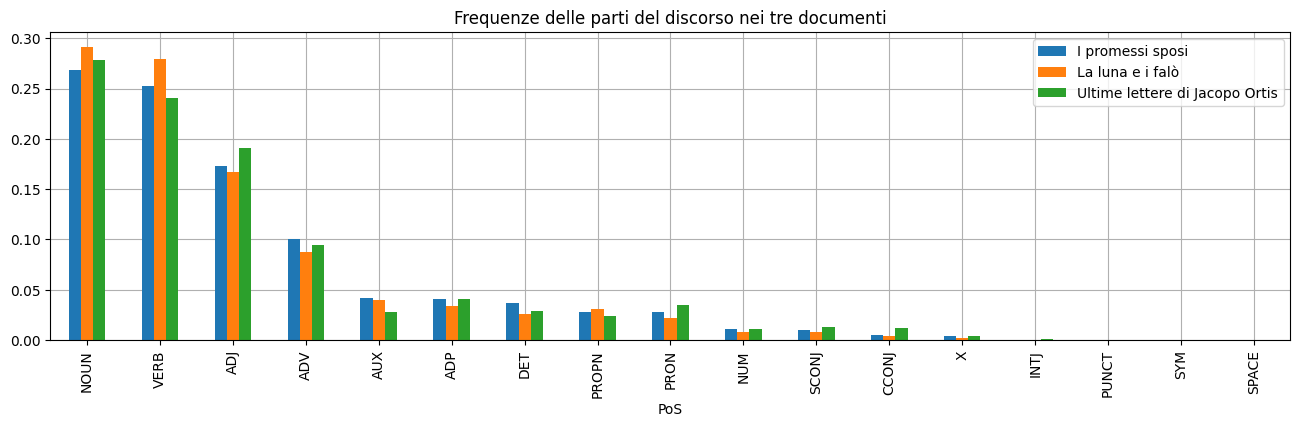

In [31]:
fig, ax = plt.subplots(figsize=(16, 4), dpi=100)
ax.set_title("Frequenze delle parti del discorso nei tre documenti")
tag_frequencies.plot(kind="bar", zorder=2, ax=ax)
ax.grid()
plt.show()

Vogliamo adesso andare a creare gli embedding e analizzarne le proprietà. Gli embedding di token, dunque di frasi, sono specifici per ciascuna lingua e quindi noi dovremo usare un modella apposito per l'italiano.

Andiamo di seguito a istanziare l'oggetto contenente il modello per i nostri embedding, tramite la libreria ```flair```. Questo modello è stato allenato su un corpus di documenti contenente delle pagine italiane di Wikipedia.

In [33]:
! pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 69.6 MB/s eta 0:00:00


In [34]:
italian_embedding = WordEmbeddings("it")

Per testare come si comporta questo modello su singole parole, possiamo considerare una frase come costituita da una un'unica parola. Andiamo quindi a costruire gli embedding per queste singole parole e raccogliamoli in una matrice.

Questa matrice ha tante sono le parole considerate un numero di colonne pari a $300$, ovvero la dimensione di ciascun embedding ottenuto specificatamente per la lingua italiana.

In [35]:
sentences = [
    Sentence("Renzo"),
    Sentence("Lucia"),
    Sentence("Abbondio"),
    Sentence("Jacopo"),
    Sentence("Fede"),
    Sentence("Speranza"),
    Sentence("Carità"),
    Sentence("Gesù"),
]
embeddings = []
for sentence in sentences:
    italian_embedding.embed(sentence)
    for token in sentence:
        embeddings.append(token.embedding.numpy())
embeddings = np.stack(embeddings)

Dati con $300$ dimensioni non possono essere visualizzati, però possiamo cercare di un modo di ridurre queste dimensioni in modo da ottenere un rappresentazione grafica. Per visualizzare gli embedding su un piano, dobbiamo ridurre le dimensioni a $2$.

Come tecnica per la riduzione delle dimensioni usiamo l'analisi delle componenti principali: andiamo a costruire le $2$ componenti più rappresentative della variabilità dei dati. Effettuiamo una sorta di priezione bidimensionale dei nostri dati.

In [36]:
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

Nella prossima figura visualizziamo le prime $2$ componenti principali degli embedding su un piano, in modo da poter valutare la distanza tra gli embedding.

Le prime quattro parole, tutti nomi propri, sono raggruppate verso destra, intorno a valori molto simili della prima componente principale. Le successive tre parole sono le tre virtù teologali, raggruppate in una zona del piano diversa, ma ancora con valori simili della prima componenente principale.

La parola Gesù sembra molto più affine alle virtù teologali rispetto che hai nomi propri, pur essendo un nome proprio lui stesso. Questo accade probabilmente perché sematicamento è un termine associato più frequentemente alla sfera religiosa piuttosto che a quella dei nomi propri, almeno all'interno del corpus di dati con cui sono stati costruiti gli embedding.

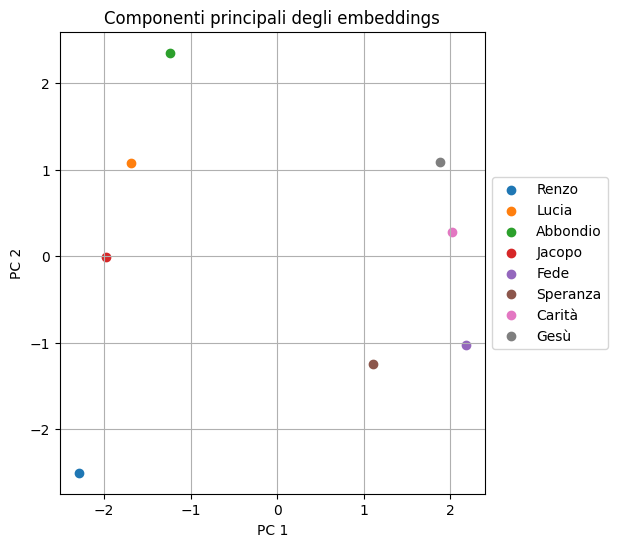

In [37]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ax.set_title("Componenti principali degli embeddings")
for i in range(embeddings_pca.shape[0]):
    ax.scatter(embeddings_pca[i, 0], embeddings_pca[i, 1], label=sentences[i].text)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.grid()
ax.set_aspect("equal")
plt.show()

Vogliamo ora andare a creare degli embedding di frasi. Per prima cosa, andiamo a costuire un dizionario, con un ingresso per ciascun documento, contenente una lista di tutte le frasi di quel documento, inclusa la punteggiatura. Gli embedding che andiamo ad utilizzare accettano anche parole con le maiscole, quindi non serve convertirle preventivamente.

In [38]:
sentences = {}
for name, file in zip(names, files):
    sentences[name] = [" ".join(tokens) for tokens in corpus.sents(fileids=file)]

Possiamo adesso andare a creare gli embeddings per ciascuna frase. Il modo più semplice che possiamo utilizzare è calcolare una media degli embedding delle parole della frase. Andiamo anche a costruire una vettore in cui a ciascun embedding andiamo ad associare il romanzo da cui proviene.

In [39]:
sentences_embeddings = []
documents = []
for name in names:
    for sentence in sentences[name]:
        sentence_ = Sentence(sentence)
        italian_embedding.embed(sentence_)
        sentences_embedding = np.zeros(300)
        for word in sentence_:
            sentences_embedding += word.embedding.numpy() / len(sentence_)
        sentences_embeddings.append(sentences_embedding)
        documents.append(name)
sentences_embeddings = np.array(sentences_embeddings)
documents = np.array(documents)

Andiamo adesso a selezionare gli embedding delle prime due frasi de I promessi sposi, de La luna e i falò e delle Ultime lettere di Jacopo Ortis. Svogliamo questa operazione manualmente, perché vengono contate anche come frasi iniziali anche i titoli, gli autori e ogni elemento accessorio che viene prima dell'inizio vero e proprio del romanzo.

In [40]:
print("I promessi sposi:")
print(sentences["I promessi sposi"][86])
print(sentences["I promessi sposi"][87])
print("\nLa luna e i falò:")
print(sentences["La luna e i falò"][6])
print(sentences["La luna e i falò"][7])
print("\nUltime lettere di Jacopo Ortis:")
print(sentences["Ultime lettere di Jacopo Ortis"][16])
print(sentences["Ultime lettere di Jacopo Ortis"][17])

I promessi sposi:
Quel ramo del lago di Como , che volge a mezzogiorno , tra due catene non interrotte di monti , tutto a seni e a golfi , a seconda dello sporgere e del rientrare di quelli , vien , quasi a un tratto , a ristringersi , e a prender corso e figura di fiume , tra un promontorio a destra , e un ’ ampia costiera dall ’ altra parte ; e il ponte , che ivi congiunge le due rive , par che renda ancor più sensibile all ’ occhio questa trasformazione , e segni il punto in cui il lago cessa , e l ’ Adda rincomincia , per ripigliar poi nome di lago dove le rive , allontanandosi di nuovo , lascian l ’ acqua distendersi e rallentarsi in nuovi golfi e in nuovi seni .
La costiera , formata dal deposito di tre grossi torrenti , scende appoggiata a due monti contigui , l ’ uno detto di san Martino , l ’ altro , con voce lombarda , il Resegone , dai molti suoi cocuzzoli in fila , che in vero lo fanno somigliare a una sega : talchè non è chi , al primo vederlo , purchè sia di fronte , come

Andiamo a selezionare i soli embedding per queste frasi, ottenendo così una matrice con $6$ righe e $300$ colonne. Selezioniamo anche i romanzi da cui provengono queste frasi.

In [41]:
selected_sentences_embeddings = np.concatenate(
    (
        sentences_embeddings[86:88],
        sentences_embeddings[
            len(sentences["I promessi sposi"])
            + 6 : len(sentences["I promessi sposi"])
            + 8
        ],
        sentences_embeddings[
            len(sentences["I promessi sposi"])
            + len(sentences["La luna e i falò"])
            + 16 : len(sentences["I promessi sposi"])
            + len(sentences["La luna e i falò"])
            + 18
        ],
    )
)
selected_documents = [
    "I promessi sposi",
    "I promessi sposi",
    "La luna e i falò",
    "La luna e i falò",
    "Ultime lettere di Jacopo Ortis",
    "Ultime lettere di Jacopo Ortis",
]

Andiamo di seguito a costruire le $2$ componenti principali per le frasi appena selezionate. Andiamo anche a costruire una lista di colori che ci sarà utile per leggere meglio la figura che otterremo, in modo da colorare allo stesso modo le prime $2$ componenti principali embedding di frasi provenienti dallo stesso romanzo.

In [42]:
pca = PCA(n_components=2)
selected_sentences_embeddings_pca = pca.fit_transform(selected_sentences_embeddings)
colors = [
    "tab:blue",
    "tab:blue",
    "tab:orange",
    "tab:orange",
    "tab:green",
    "tab:green",
]

Andiamo adesso a visualizzare graficamente le prime $2$ componenti principali degli embedding delle prime due frasi per ciascun romanzo.

Quello che appare da questa analisi qualitativa è che frasi dello stesso romanzo sono collocate in regioni specifiche dello spazio. I limiti di questa interpretazione stanno nel fatto che stiamo visualizzando solo $2$ delle $300$ componenti principali, che in linea di principio sono tante quante l'originale dimensionalità degli embedding.

Inoltre, non è detto che le prime $2$ componenti principali degli embedding delle altre frasi siano chiaramente separate.

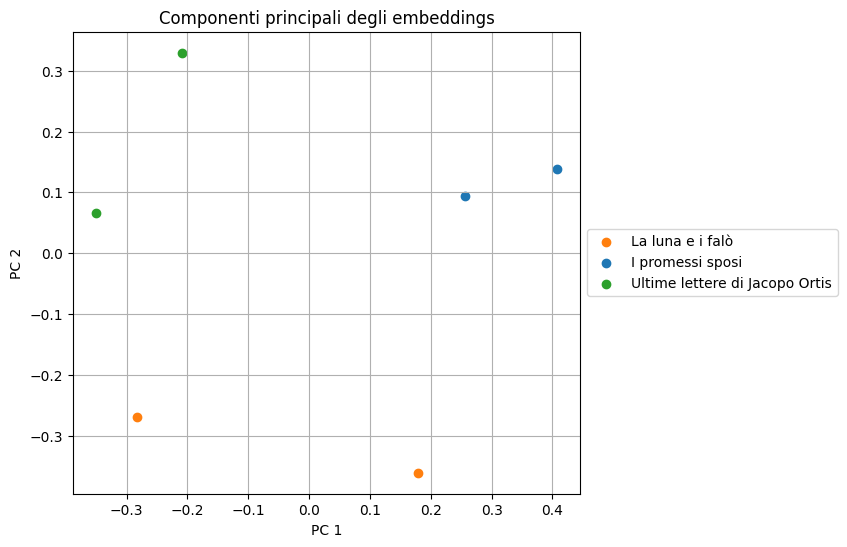

In [43]:
fig, ax = plt.subplots(figsize=(21, 6), dpi=100)
ax.set_title("Componenti principali degli embeddings")
for i in range(selected_sentences_embeddings_pca.shape[0]):
    ax.scatter(
        selected_sentences_embeddings_pca[i, 0],
        selected_sentences_embeddings_pca[i, 1],
        label=selected_documents[i],
        c=colors[i],
    )
handles, labels = ax.get_legend_handles_labels()
unique_labels = set(labels)
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels, loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.grid()
ax.set_aspect("equal")
plt.show()

Alla luce delle considerazioni qualitative dell'esempio precedente, possiamo cercare di creare un modello in grado di classificare frasi dei diversi autori. indicando a quale dei nostri tre romanzi appartengono. Questo compito viene svolto a partire dagli embedding delle frasi che abbiamo appena ottenuto.

Quando vogliamo andare a fare delle prove di classificazione, vogliamo allenare un modello su insieme di dati di train e poi valutarne le performance su dei dati di test, ovvero dati che non sono mai stati visti durante la fase di addestramento, per effettuare un confronto intellettualmente onesto e assicurarci che il nostro modello non abbia solamente imparato a memoria a etichettare i dati del train.

Andiamo di seguito a dividere i nostri dati in $80\%$ in insieme di train e il restante $20\%$ in insieme di test con la funzione ```train_test_split```. Specifichiamo un valore per lo stato casuale di inizializzazione per avere riproducibilità dei risultati.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    sentences_embeddings, documents, test_size=0.2, random_state=0
)

Precisiamo che i diversi embedding e le loro etichette, ovvero i romanzi da cui provengono, vengono mescolate per evitare che tutti i dati di test siano inerenti allo stesso autore e altri tipi di problemi di questa natura.

Il primo modello che andiamo a provare è un albero decisionale. Possiamo specificare la massima profondità dell'alberto decisionale. Anche qui, settiamo uno stato casuale riproducibile.

In [45]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=8, random_state=0)
decision_tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, random_state=0)

Per valutare la perfomance del modello, andiamo a valutarne l'accuracy: questa è la percentuale di dati classificati correttamente. Ci interessa valutare sia in fase di train, per evitare il fenomeno dell'overfitting, per cui il modello impara a memoria alcune classificazioni, sia in fase di test, per mettere alla prova il modello su dati mai visti.

Per queste valutazioni, andiamo ad utilizzare la funzione ```accuracy_score```. Riportiamo l'accuracy in percentuale.

In [46]:
print(
    f"Train accuracy: {accuracy_score(decision_tree_classifier.predict(X_train), y_train):.1%}"
)
print(
    f"Test accuracy: {accuracy_score(decision_tree_classifier.predict(X_test), y_test):.1%}"
)

Train accuracy: 80.6%
Test accuracy: 70.7%


Un altro modo per visualizzare i risulati ottenuti con questo classificatore è attraverso una matrice di confusione. Questa matrice ha tante righe quante colonne, corrispondenti a ciascun documento. Sono riportati i documenti predetti sull'asse orizzontale e quelli veri sull'asse verticale, quindi:
+ i numeri diagonali indicati quante frasi sono stati etichetti correttamente;
+ il numero alla posizione $(1,2)$ indica quante frasi sono state etichettate come appartenti al documento $1$, quando in realtà appartenevano al documenti $2$;
+ lo stesso accade per tutte le altre celle fuori dalla diagonale.

Andiamo adesso ad utilizzare la funzione ```confusion_matrix``` per costruire la matrice di confuzione che otteniamo con l'albero decisionale considerato.

In [47]:
decision_tree_classifier_cm = confusion_matrix(
    decision_tree_classifier.predict(X_test), y_test
)

Andiamo ora a visualizzare graficamente la matrice di confusione. Le celle vengono colorate in maniera più chiara maggiore è il numero di corrispondente alla cella stessa. Vediamo un accordo molto buono su I promessi sposi, mentre i risultati non sono così soddisfacenti per gli altrei due romanzi.

Questo può essere anche dovuto al fatto che il nostro insieme di dati è molto sbilanciato, visto che le frasi de I promessi sposi sono molto più numerose di quelle degli altri due romanzi. Potrebbe anche essere che l'algoritmo di classificazione pabbia imparato che in caso di dubbio è più conveniente rispondere I promessi sposi che rischiare di sbagliare provando a rispondere con uno degli altri due romanzi.

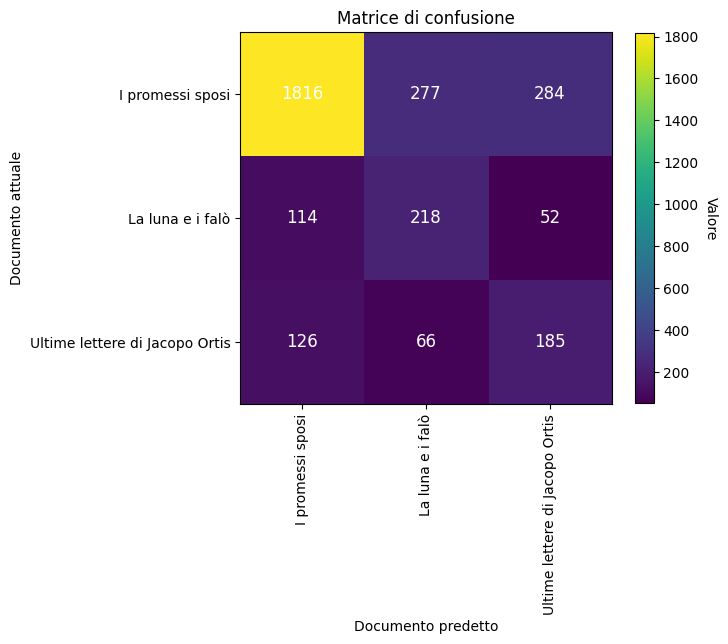

In [48]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ax.set_title("Matrice di confusione")
im = ax.imshow(decision_tree_classifier_cm)
for i in range(decision_tree_classifier_cm.shape[0]):
    for j in range(decision_tree_classifier_cm.shape[1]):
        ax.text(
            j,
            i,
            format(decision_tree_classifier_cm[i, j], "d"),
            ha="center",
            va="center",
            color="white",
            fontsize=12,
        )
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.set_ylabel("Valore", rotation=-90, va="bottom")
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=90)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
ax.set_xlabel("Documento predetto")
ax.set_ylabel("Documento attuale")
ax.set_aspect("equal")
plt.show()

Per cercare di uniformare la lettura della matrice di confusione appena ottenuta, può essere interessante mostrare i valori normalizzati, in modo da vedere le percentuali classificate correttamente e non. Andiamo quindi a calcolare la matrice di confusione normalizzata.

In [49]:
decision_tree_classifier_cm_normalized = confusion_matrix(
    decision_tree_classifier.predict(X_test), y_test, normalize="true"
)

Riportiamo di seguito la matrice di confusione normalizzata. Ora anche la lettura della barra laterale di confronto diventa anche più agevole.

Osserviamo come quando viene sbagliata la classificazione delle Ultime lettere di Jacopo Ortis, il documento predetto è molto più spesso I promessi sposi piuttosto che La luna e i falò. Questo fattore potrebbe essere spiegato dalla maggiore vicinanza temporale del romanzo di Foscolo a quello di Manzoni rispetto a quello di Pavese.

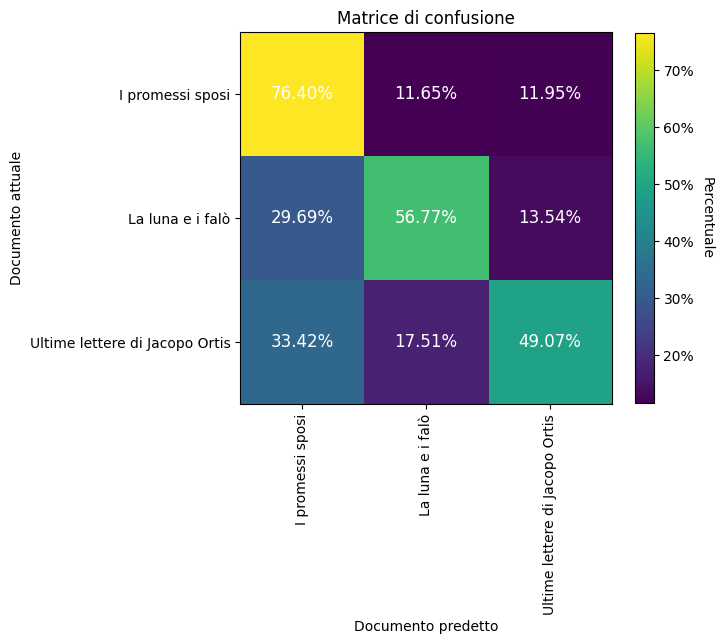

In [50]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ax.set_title("Matrice di confusione")
im = ax.imshow(decision_tree_classifier_cm_normalized)
for i in range(decision_tree_classifier_cm_normalized.shape[0]):
    for j in range(decision_tree_classifier_cm_normalized.shape[1]):
        ax.text(
            j,
            i,
            f"{decision_tree_classifier_cm_normalized[i, j]:.2%}",
            ha="center",
            va="center",
            color="white",
            fontsize=12,
        )
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.yaxis.set_major_formatter(lambda x, _: f"{x * 100:.0f}%")
cbar.ax.set_ylabel("Percentuale", rotation=-90, va="bottom")
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=90)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
ax.set_xlabel("Documento predetto")
ax.set_ylabel("Documento attuale")
ax.set_aspect("equal")
plt.show()

L'albero decisionale che abbiamo considerato fino ad ora è soltanto uno dei possibili modelli di classificazione che possiamo provare. Un'alternativa più complessa è data dalle foreste casuali. Questo modello non è altro che una collezioni di alberi decisionali, in cui ogni albero ottiene una sua previsione. Le previsioni dei diversi alberi della foresta vengono aggregato per fornire una classificazione finale.

Andiamo a istanziare questo modello usando la classe ```RandomForestClassifier```, alleniamolo e testiamolo sugli stessi dati dell'albero decisionale. Andiamo a specificare alcuni parametri della foresta che stiamo utilizzando, come il numero di alberi e la loro profondità massima, oltre che allo stato casuale per ottenere risultati riproducibili. Internamente, la foresta allena ciascun albero su una porzione casuale dei dati di train.

In [51]:
random_forest_classifier = RandomForestClassifier(
    n_estimators=100, max_depth=16, random_state=0
)
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, random_state=0)

L'avere diversi alberi all'interno della foresta aiuta a combattere l'eventuale problema di overfitting dei singoli alberi.

Osserviamo che un modello più complesso riusciamo a guadagnare circa il $10\%$ di accuracy sull'insieme di dati di test.

In [52]:
print(
    f"Train accuracy: {accuracy_score(random_forest_classifier.predict(X_train), y_train):.1%}"
)
print(
    f"Test accuracy: {accuracy_score(random_forest_classifier.predict(X_test), y_test):.1%}"
)

Train accuracy: 98.8%
Test accuracy: 77.5%


Andiamo adesso a calcolare le matrici di confusione per la foresta casuale, sia non normalizzata, dunque con i valori assoluti dei conteggi, sia normalizzata.

In [53]:
random_forest_classifier_cm = confusion_matrix(
    random_forest_classifier.predict(X_test), y_test
)
random_forest_classifier_cm_normalized = confusion_matrix(
    random_forest_classifier.predict(X_test), y_test, normalize="true"
)

Andiamo adesso ad osservare la matrice di confunsione con i valori assoluti dei conteggi. Ricordiamo che la matrice di confusione è valutata sull'insieme di test. Vediamo che i numeri fuori diagonale sono più piccoli rispetto al modello dell'albero decisionale, simbolo che il modello è più accurato nella previsione. Di conseguenza, i valori diagonali sono più alti rispetto alla matrice di confusione dell'albero singolo.

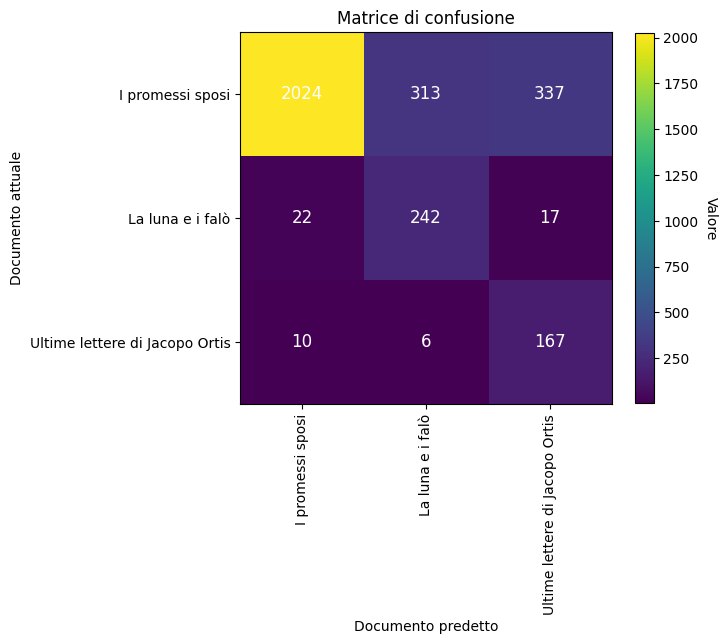

In [54]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ax.set_title("Matrice di confusione")
im = ax.imshow(random_forest_classifier_cm)
for i in range(random_forest_classifier_cm.shape[0]):
    for j in range(random_forest_classifier_cm.shape[1]):
        ax.text(
            j,
            i,
            format(random_forest_classifier_cm[i, j], "d"),
            ha="center",
            va="center",
            color="white",
            fontsize=12,
        )
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.set_ylabel("Valore", rotation=-90, va="bottom")
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=90)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
ax.set_xlabel("Documento predetto")
ax.set_ylabel("Documento attuale")
ax.set_aspect("equal")
plt.show()

Il miglioramento è ancora più leggibile a colpo d'occhio se andiamo ad osservare la matrice di confusione con i valori percentuali. In particolare, qui è ancora più evidente come siano molto più alte per le percentuali sulla diagonale rispetto al modello con un singolo albero.

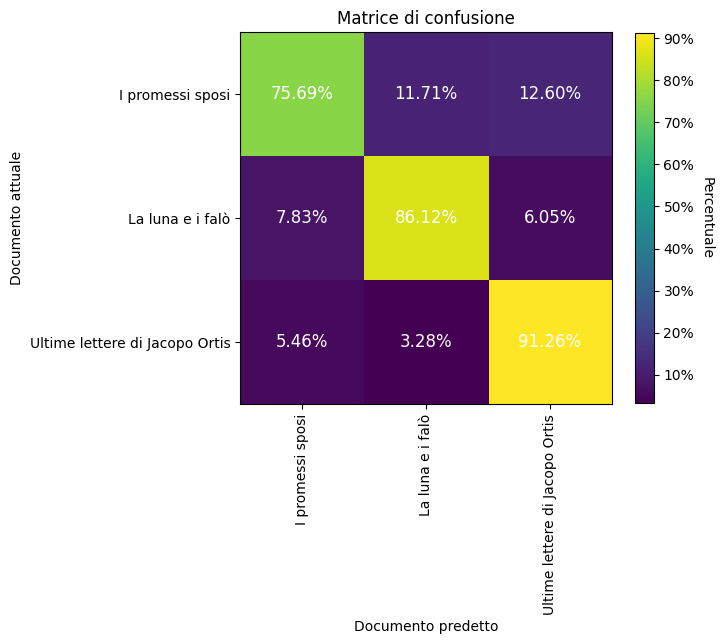

In [55]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ax.set_title("Matrice di confusione")
im = ax.imshow(random_forest_classifier_cm_normalized)
for i in range(random_forest_classifier_cm_normalized.shape[0]):
    for j in range(random_forest_classifier_cm_normalized.shape[1]):
        ax.text(
            j,
            i,
            f"{random_forest_classifier_cm_normalized[i, j]:.2%}",
            ha="center",
            va="center",
            color="white",
            fontsize=12,
        )
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.yaxis.set_major_formatter(lambda x, _: f"{x * 100:.0f}%")
cbar.ax.set_ylabel("Percentuale", rotation=-90, va="bottom")
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=90)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
ax.set_xlabel("Documento predetto")
ax.set_ylabel("Documento attuale")
ax.set_aspect("equal")
plt.show()

Concludiamo dicendo che i due modelli che abbiamo considerato sono soltanto due degli innumerevoli possibili modelli, che possono essere in linea di principio anche molto più complessi di quelli visti. Ci possiamo aspettare quindi di poter ottenere risultati ancora migliori usando modelli più complessi.

Per fare un esempio su tutti, possiamo vedere cosa succede usando una regressione logistica. Questa tecnica è utilizzata per assegnare a ciascuna della possibili categorie una probabilità e va poi ad assegnare come categoria predetta quella con la probabilità più alta.

Andiamo a creare un'istanza di questo modello tramite le classe ```LogisticRegression``` e inizializziamo uno stato casuale per avere risultati riproducibili. Andiamo anche a specificare $500$ come numero massimo di iterazioni durante la fase di addestramento del modello. Alleniamo poi questo modello e valutiamo la sua performance sull'insieme di test. Vediamo che raggiungiamo un'accuracy sull'insieme di test anche superiore alla foresta casuale.

In [56]:
logistic_regression = LogisticRegression(max_iter=500, random_state=0)
logistic_regression.fit(X_train, y_train)
print(
    f"Train accuracy: {accuracy_score(logistic_regression.predict(X_train), y_train):.1%}"
)
print(
    f"Test accuracy: {accuracy_score(logistic_regression.predict(X_test), y_test):.1%}"
)

Train accuracy: 86.6%
Test accuracy: 84.6%


Andiamo ora a calcolare entrambe le matrici di confusione per una valutazione più precisa di questa tecnica più sofisticata.

In [57]:
logistic_regression_cm = confusion_matrix(logistic_regression.predict(X_test), y_test)
logistic_regression_cm_normalized = confusion_matrix(
    logistic_regression.predict(X_test), y_test, normalize="true"
)

Visualizziamo la matrice di confusione con i valori assoluti dei conteggi. Valgono ancora le stesse considerazioni di prima. Notiamo che anche con un modello più complesso, quando viene erroneamente classificato le Ultime lettere di Jacopo Ortis, il romanzo predetto è più spesso I promessi sposi che La luna e i falò.

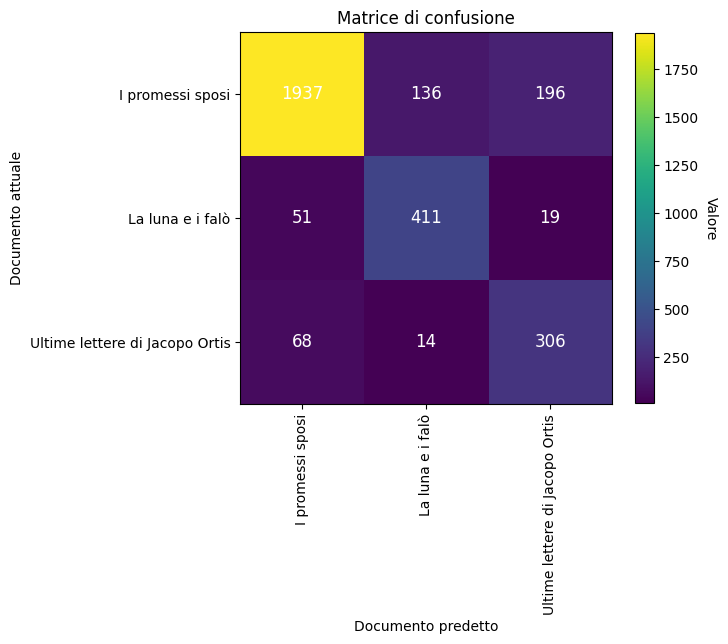

In [58]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ax.set_title("Matrice di confusione")
im = ax.imshow(logistic_regression_cm)
for i in range(logistic_regression_cm.shape[0]):
    for j in range(logistic_regression_cm.shape[1]):
        ax.text(
            j,
            i,
            format(logistic_regression_cm[i, j], "d"),
            ha="center",
            va="center",
            color="white",
            fontsize=12,
        )
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.set_ylabel("Valore", rotation=-90, va="bottom")
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=90)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
ax.set_xlabel("Documento predetto")
ax.set_ylabel("Documento attuale")
ax.set_aspect("equal")
plt.show()

Analizziamo infine la matrice di confusione con i valori percentuali. Osserviamo ora che i valori diagonali sono più uniformemente alti rispetto ai modelli precedenti, e di conseguenza anche i valori fuori diagonale sono più bassi. Questo fenomeno è indice del fatto che il modello ha imparato a classificare in maniera soddisfacente ciascuno dei tre romanzi considerati.

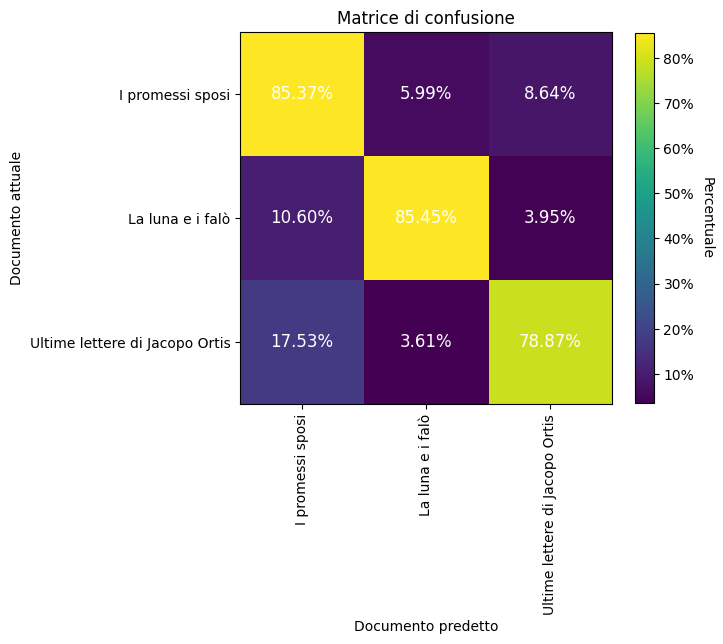

In [59]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ax.set_title("Matrice di confusione")
im = ax.imshow(logistic_regression_cm_normalized)
for i in range(logistic_regression_cm_normalized.shape[0]):
    for j in range(logistic_regression_cm_normalized.shape[1]):
        ax.text(
            j,
            i,
            f"{logistic_regression_cm_normalized[i, j]:.2%}",
            ha="center",
            va="center",
            color="white",
            fontsize=12,
        )
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.yaxis.set_major_formatter(lambda x, _: f"{x * 100:.0f}%")
cbar.ax.set_ylabel("Percentuale", rotation=-90, va="bottom")
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=90)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
ax.set_xlabel("Documento predetto")
ax.set_ylabel("Documento attuale")
ax.set_aspect("equal")
plt.show()